# IDA* search

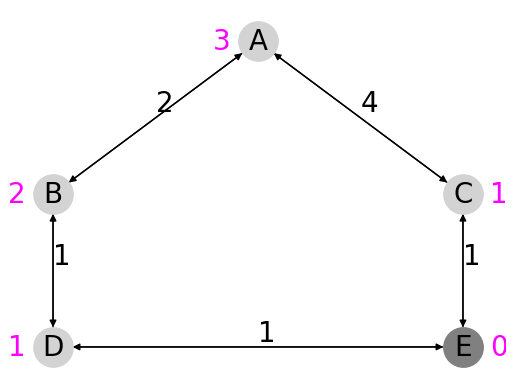

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
# G is a graph represented as an adjancency list. 
# G is a hash table (dictionary) with each node as a key, and value, the list of adjacent nodes
G={'A':['B','C'],'B':['A','D'],'C':['A','E'],'D':['B','E'],'E':['C','D']}
W={('A','B'): 2, ('B','A'): 2, ('A', 'C'): 4, ('C','A'): 4, ('C','E'): 1, ('E','C'): 1, ('B','D'): 1, ('D','B'): 1, ('D','E'): 1, ('E','D'): 1}
h={"A": 3, "B": 2, "C": 1, "D": 1, "E": 0}
lab_h = {}
for i in h: lab_h[i] = str(h[i])
nxG=nx.DiGraph(G)
nx.set_edge_attributes(nxG, values = W, name = 'weight')
source='A'
Target=['E']
pos_nodes = {'A': (20, 300), 'B': (10, 200), 'C': (30, 200), 'D': (10, 100), 'E': (30, 100)}
pos_h = {'A': (18.25, 300), 'B': (8.25, 200), 'C': (31.75, 200), 'D': (8.25, 100), 'E': (31.75, 100)}
nx.draw_networkx_edge_labels(nxG, pos=pos_nodes,edge_labels=W,font_size=20,
  horizontalalignment="left",verticalalignment="bottom",rotate=False, label_pos=0.5)
nx.draw_networkx_labels(nxG, pos_h, labels=lab_h, font_size=20, font_color="magenta")
nx.draw(nxG,pos=pos_nodes, with_labels=True, node_color="lightgray", node_size=800, font_size=20)
nx.draw_networkx_nodes(nxG,pos=pos_nodes, nodelist=Target, node_color='gray', node_size=800)


## IDA* algorithm with graph search

BT(G, path, $g_s$, $h$, bound)  
> $s$ = Top(path)  
> $f_s = g_s + h(s)$  
> if $f_s$ > bound  return ($f_s$, NULL)  
> if Target($s$)   return ($f_s$, s)  
> min = $\infty$  
> n = FirstAdjacent(G,s)  
> while n $\neq$ NULL
>>  if n $\notin$ path  
>>>   $g_n$ = $g_s$ + $w(s,n)$  
>>>   Push(path,n)  
>>>   next_bound, target = BT(G, path, $g_n$, $h$, bound)  
>>>   if target $\neq$ NULL return (next_bound, target)  
>>>   if next_bound < min min = next_bound  
>>>   Pop(path)  
>>>   $n$ = NextAdjacent(G, $s$, $n$)  
> return (min, NULL)  

IDA*($G$, source, $h$)  
> bound = h(source)  
> path = InitStack(source)  
> while  
>>  (next_bound, target) = BT($G$, path, $h$, bound)  
>>  if target $\neq$ NULL  
>>>   return path  
>>  if next_bound < 0  
>>>   return NULL  
>>  bound = next_bound




## IDA* implementation with graph search returning path

In [7]:
import math

def bt(G, W, path, gs, h, bound, Target):
  s = path[-1]
  fs = gs + h[s]
  if fs > bound:
    return (fs, None)
  if s in Target: 
    return (fs, s)
  min = math.inf
  for n in iter(G[s]):
    if n not in path:
      gn = gs + W[(s,n)]
      fn = gn + h[n]
      path.append(n)
      (next_bound, target)  = bt(G, W, path, gn, h, bound, Target)
      if target != None: return (next_bound, target)
      if next_bound < min: min = next_bound
      path.pop(-1)
  return min, None

def idastar(G, W, s, h, Target):
  path = [s]
  bound = h[s]
  while True:
    (next_bound,target) = bt(G, W, path, 0, h, bound, Target)
    if target != None: return (next_bound, path)
    if next_bound < 0: return (next_bound, None)
    bound = next_bound

          
print(idastar(G,W,source,h,Target))

(4, ['A', 'B', 'D', 'E'])


## IDA* implementation with graph search showing nodes stored in memory

(4, ['A', 'B', 'D', 'E'])


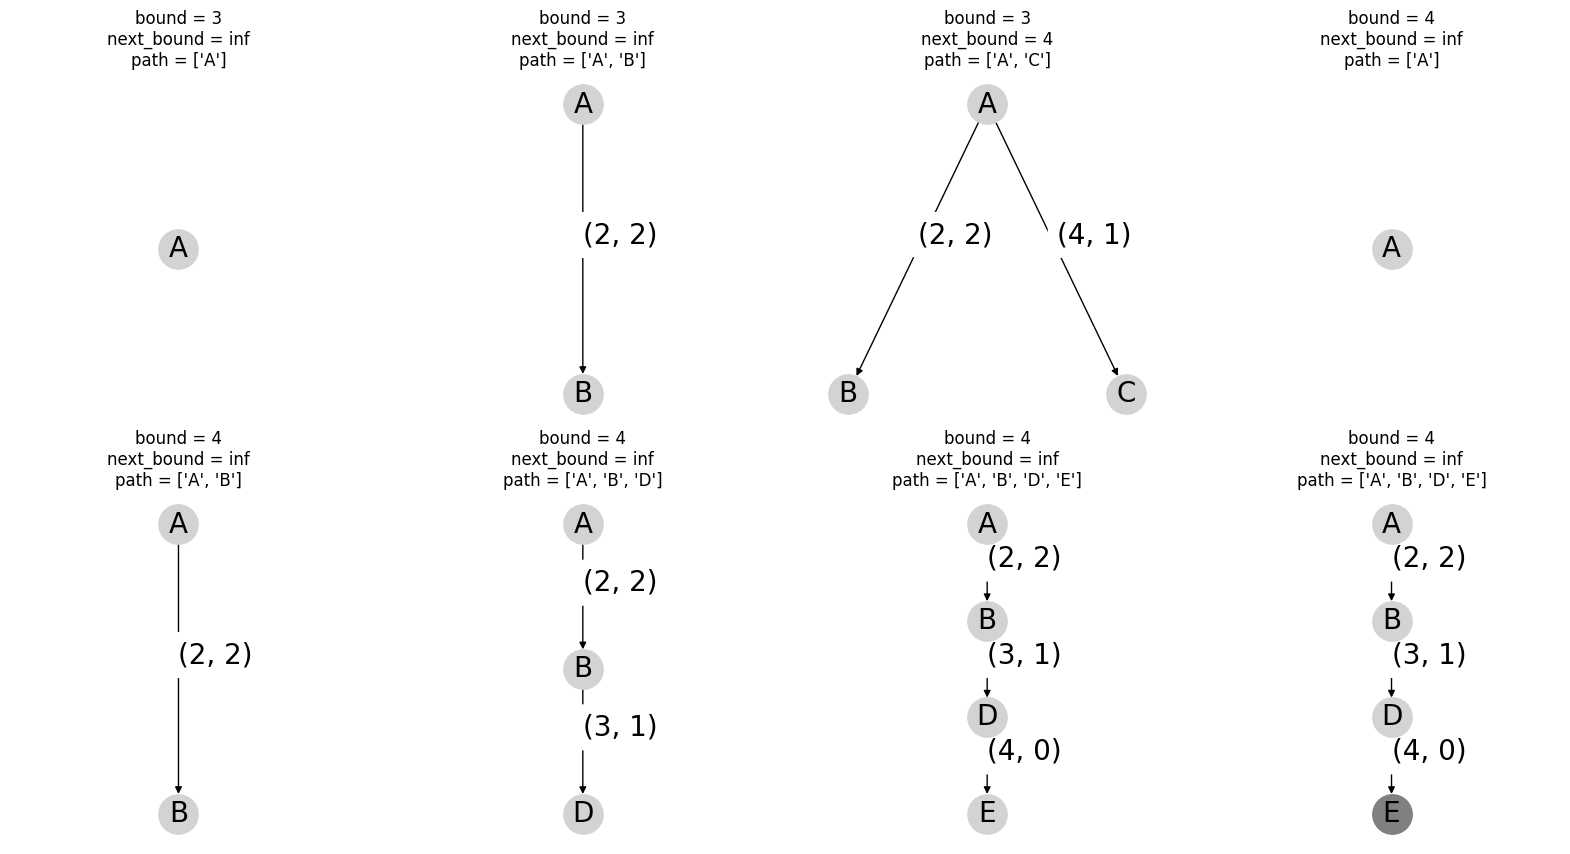

In [4]:
import matplotlib.pyplot as plt
import math

nrows=2; ncols=4
fig, _ = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = iter(fig.axes)

def draw_graph(DG, DW, source, path, bound, next_bound = math.inf, target=[],):
  nxDG=nx.DiGraph(DG)
  ax = next(axes)
  title = "bound = " + str(bound) + "\n" 
  title+= "next_bound = " + str(next_bound) + "\n" 
  title+= "path = " + str(path )
  ax.set_title(title) 
  pos_nodes = nx.nx_agraph.pygraphviz_layout(nxDG,prog='dot',root=source)
  nx.draw(nxDG,pos=pos_nodes, ax=ax, with_labels=True, node_color="lightgray", node_size=800, font_size=20)
  nx.draw_networkx_edge_labels(nxDG, pos=pos_nodes, edge_labels=DW, label_pos=0.5, font_size=20, 
    horizontalalignment="left",verticalalignment="bottom", ax=ax, rotate=False)
  nx.draw_networkx_nodes(DG, pos=pos_nodes, ax=ax, nodelist=target, node_color='gray', node_size=800)

def bt(G, W, path, gs, h, bound, Target):
  s = path[-1]
  fs = gs + h[s[0]]
  if fs > bound:
    return (fs, None)
  if s in Target: 
    draw_graph(DG, DW, source, path, bound, math.inf, [s])
    return (fs, s)
  min = math.inf
  Adj = DG[s]; 
  for n in iter(G[s[0]]):
    if n not in path:
      gn = gs + W[(s[0],n)]
      fn = gn + h[n]
      path.append(n)
      while n in DG: n+="'"
      Adj.append(n); DG[s]=Adj; DG.update({n:[]}); DW.update({(s,n):(gn,fn-gn)})
      draw_graph(DG, DW, source, path, bound, min)
      (next_bound, target)  = bt(G, W, path, gn, h, bound, Target)
      #Adj.remove(n); DG[s]=Adj; del DG[n]; del DW[(s,n)]
      #draw_graph(DG, DW, source, bound, min)  
      if target != None: return (next_bound, target)
      if next_bound < min: min = next_bound
      path.pop(-1)
  return min, None

def idastar(G, W, s, h, Target):
  path = [s]
  bound = h[s]
  while True:
    DG.update({source:[]})
    draw_graph(DG, DW, source, path, bound)
    (next_bound,target) = bt(G, W, path, 0, h, bound, Target)
    if target != None: return (next_bound, path)
    if next_bound < 0: return (next_bound, None)
    bound = next_bound
    DG.clear(); DW.clear()

DG = {}; DW = {}
print(idastar(G,W,source,h,Target))